<a href="https://colab.research.google.com/github/mrmartinez5/DeepLearning/blob/master/312_Martinez_Michael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Created by: Michael Martinez
# Cougar ID: 1091442
# For: IDL 312
# File created 11/6/2022

# Intent: this tutorial demonstrates how a neural network performs a classification
# computer vision task using code and an accompanying model card.

# Dataset: 

# Code Objectives:
# 1 pt = code runs without errors

# Model Card Objectives (explain and discuss):
# 1 pt = model description (input = 299x299 pixels, output, architecture = inception_resnet_v2, sequential stacks our hidden layers (Keras, dropout, dense)) 
# 1 pt = training hyperparameters and procedure (loss function = CategoricalCrossentropy, optimizer = SGD, augmentation = true, fine_tuning = true, dropout = 0.2)
# 1 pt = model performance results and evaluation methods
# 1 pt = intended uses and potential limitations
# 0 pt = describe the issues and suggest potential improvements

#Image classifer for flowers
Intended use:

I chose to work with an image classifier because I'm interested in building several for my Ph.D. work with sedimentary rocks.

This classifier is intended to take a random image from the (test?) dataset and predict it's class with high accuracy.

Limitations:

This model only "knows" 5 classes of flowers, so it won't work for every flower in the world.

I did a very small amount of hyperparameter tuning and could do a better job to squeeze out some accuracy if our task required that. However, ~82% is acceptable for a rough first model.

#IMPORTING LIBRARIES AND SETUP

Attempted to take advantage of tensorflow public datasets by imports but couldn't get it to work for this submission.

In [5]:
#import itertools
#import os
#import re

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_datasets.public_api as tfds

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
GPU is available


#IMPORTING A PRE-TRAINED DL MODEL: inception_resnet_v2
Reason: Chose inception_resnet_v2 based on "An Analysis of Deep Neural Network Models for Practical Applications" (Canziani, Culurciello, Paszke, 2017).

Intent: Good accuracy with low-moderate # of total operations.

Other comments: Purged out the unused model references. Changed batch_size based on hyperparameter trial and error tinkering.

In [6]:
model_name = "inception_resnet_v2" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
}

model_image_size_map = {
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

# Input size for inception_resnet_v2 = (299,299) pixels
IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

# Reduced batch size from 16 to 4 based on trial and error
# hyperparameter tuning
BATCH_SIZE = 4#@param {type:"integer"}

Selected model: inception_resnet_v2 : https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5
Input size (299, 299)


#SET UP THE flower_photos DATASET
I had trouble uploading or calling on any other dataset, so I used the default tf_flowers dataset 

https://www.tensorflow.org/datasets/catalog/tf_flowers

This does the job for a classification problem because it has 3670 images that can be divided into 5 classes and the 3670 images are split into training and validation sets.

In [7]:
## I tried to bring in the 101_objectcategories caltech dataset for this project
## https://www.tensorflow.org/datasets/catalog/caltech101
## but I had trouble targeting a .tgz file without subscribing to Google API's.
## I thought about loading them into the folder here, but then you might have trouble
## running the code without the dataset in your own folder.

#data_dir = tf.keras.utils.get_file(
#    '101_ObjectCategories',
#    'https://drive.google.com/file/d/1sc6v1cHrxJNaAhIf_L38MhLy-Tl9lLc0/view?usp=share_link',
#    untar=True)

## I settled for the default tf_flowers dataset:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 10s 0us/step


#Build out the dataset
I changed the validation split from the standard 80/20.

I tinkered with the data augmentation hyperparameters as follows:

Rotation = 40 -> 35;
Translation = 20 -> 25;
Zoom (OUT) = +20-30 %;
Flip = kept horizontal 

In [8]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      ## I upped the validation split from 0.2 to 0.25
      validation_split=.25,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  #rotation
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(35))
  #translation
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.25))
  #translation
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.25, 0))
  
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  
  #zoom out
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.3))
  #flip
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2753 files for training.


Found 3670 files belonging to 5 classes.
Using 917 files for validation.


#DEFINING THE MODEL
Enabled fine tuning.
Changed dropout rate from .2 -> .25 to help with overfitting

Called on sequential architecture to stack the hidden layers because we're working with perception type deep learning.

In [9]:
do_fine_tuning = True #@param {type:"boolean"}

print("Building model with", model_handle)
model = tf.keras.Sequential([
    
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    
    #Change dropout hyperparameter from 0.2 -> 0.25
    tf.keras.layers.Dropout(rate=0.25),
    
    # Default values used for kernel and bias values
    # Susceptible to over/underfitting here
    # without a "good first guess"
    tf.keras.layers.Dense(len(class_names), #connects every output to the previous layer
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              54336736  
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 54,344,421
Trainable params: 54,283,877
Non-trainable params: 60,544
_________________________________________________________________


#TRAINING THE MODEL

Optimizer: Stuck with Stochastic Gradient Descent optimizer as a standard approach for adjusting weights that affect the error % the most. 

Could have tried other optimizers from:
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

Adjusted LR hyperparameter from 0.005 -> 0.002

Loss function: Stuck with Cross-entropy over L2.

Fitting: Adjusted epochs from 5 -> 3. Steps per epoch is larger due to reduced batch size earlier in the code.

In [10]:
model.compile(
  #stochastic gradient descent optimizer
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9), 
  
  #loss function = categorical crossentropy
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [11]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3
688/688 [==============================] - 279s 348ms/step - loss: 1.4641 - accuracy: 0.7271 - val_loss: 2.0585 - val_accuracy: 0.7380
Epoch 2/3
688/688 [==============================] - 240s 346ms/step - loss: 1.2657 - accuracy: 0.8381 - val_loss: 1.4987 - val_accuracy: 0.8035
Epoch 3/3
688/688 [==============================] - 238s 346ms/step - loss: 1.1744 - accuracy: 0.8891 - val_loss: 2.3768 - val_accuracy: 0.8286


#Model performance results and evaluation methods

The model's accuracy could be improved with more epochs and better hyperparameter tuning. 

My model isn't converging, which could be because I have some bad first guesses for hyperparameters. 

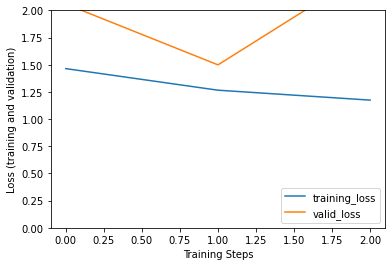

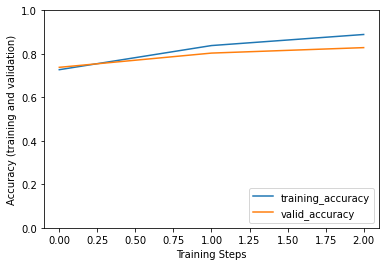

In [20]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], label = "training_loss")
plt.plot(hist["val_loss"], label = "valid_loss")
plt.legend(loc=4)

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], label = "training_accuracy")
plt.plot(hist["val_accuracy"], label = "valid_accuracy")
plt.legend(loc=4)

#Classifying an image
Pulls an image from the dataset and predicts its class.

Fails ~10% of the time. Could improve this.

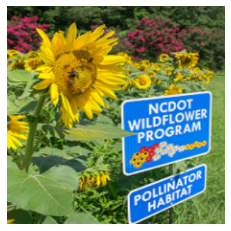

1/1 [==============================] - 0s 40ms/step
True label: sunflowers
Predicted label: sunflowers


In [21]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

#Potential improvements
I'd like to implement Rlib for its hyperparameter tuning functionalities. At present, the user has to tinker with the values themselves. Rlib could automate this process and help pick the best combinations.

Additionally, a more diverse model would have more photos from more classes of flowers. At present, this model is good for determining whether a flower is 1 of 5 classes that it knows about.